# RL vs LSM Analysis

Concise comparison of a reinforcement learning (RL) swing option pricer versus a Longstaff–Schwartz Monte Carlo (LSM) benchmark for the same monthly contract and HHK process used in the runs. Parameters are summarized in `run.sh` (8192 training paths; evaluation batches of 4096; 22 daily exercise rights; strike 1.0; Q_max 20; OU+jump spot dynamics).

In [1]:
# Parameters (edit these paths as needed)
LSM_path = "/Users/alexanderithakis/Documents/GitHub/D4PG-QR-FRM/logs/SwingOption_11/evaluations/lsm.csv"
RL_path  = "/Users/alexanderithakis/Documents/GitHub/D4PG-QR-FRM/logs/SwingOption_11/evaluations/rl_episode_8192.csv"
K = 1.0      # strike (from run.sh)
r = 0.05     # risk-free rate (annualized)
maturity = 0.0833  # years (~1 month)
n_rights = 22
DT = maturity / n_rights
Q_MAX = 20.0

In [2]:
# Imports and settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
pd.set_option('display.float_format', lambda x: f'{x:,.6f}')
sns.set_context('talk'); sns.set_style('whitegrid')

In [3]:
# Load evaluation CSVs
def load_eval_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    # Normalize column names
    df.columns = [c.strip() for c in df.columns]
    # Required minimal schema
    cols = set(df.columns)
    payoff_candidates = ['reward', 'Payoff', 'payoff']
    assert any(c in cols for c in payoff_candidates), 'Missing reward/Payoff column'
    assert 'path' in cols and 'time_step' in cols and 'q_t' in cols, 'Missing core columns'
    return df


df_rl = load_eval_csv(RL_path)
df_lsm = load_eval_csv(LSM_path)
# Identify payoff column per file
cands = ['reward', 'Payoff', 'payoff']
pay_col_rl  = next(c for c in cands if c in df_rl.columns)
pay_col_lsm = next(c for c in cands if c in df_lsm.columns)
len(df_rl), len(df_lsm), pay_col_rl, pay_col_lsm

(87968, 90112, 'reward', 'payoff')

In [4]:
rldf = pd.read_csv(RL_path).sort_values(by=['path', 'time_step']).reset_index(drop=True)
rldf.describe()

,path,time_step,Payoff,q_exercised_norm,q_remaining_norm,time_to_maturity_norm,normalized_time,spot,X_t,Y_t,days_since_exercise_norm,q_t,reward
count,"87,968.000000","87,968.000000","87,968.000000","87,968.000000","87,968.000000","87,968.000000","87,968.000000","87,968.000000","87,968.000000","87,968.000000","87,968.000000","87,968.000000","87,968.000000"
mean,"2,047.347638",10.268711,0.020612,0.308983,0.691017,0.558633,0.466760,1.020612,-0.007129,0.009902,0.102494,0.850943,0.118386
std,"1,182.232942",6.239361,0.199802,0.284339,0.284339,0.297113,0.283607,0.199802,0.177982,0.055600,0.094918,0.926611,0.269428
min,0.000000,0.000000,-0.652816,0.000000,0.000000,0.047619,0.000000,0.347184,-1.057900,0.000000,0.000000,0.000000,0.000000
25%,"1,023.000000",5.000000,-0.103133,0.018952,0.492553,0.285714,0.227273,0.896867,-0.114631,0.000000,0.045455,0.000000,0.000000
50%,"2,048.500000",10.000000,0.000000,0.262825,0.737175,0.571429,0.454545,1.000000,0.000000,0.000000,0.045455,0.207035,0.000000
75%,"3,071.000000",16.000000,0.118520,0.507447,0.981048,0.809524,0.727273,1.118520,0.101791,0.000000,0.136364,1.999996,0.107174
max,"4,095.000000",21.000000,5.214147,1.000000,1.000000,1.047619,0.954545,6.214147,0.774260,1.961176,0.681818,2.000000,10.424158


In [45]:
pd.read_csv(LSM_path).sort_values(by=['path', 'time_step']).reset_index(drop=True).describe()

,path,time_step,spot,q_exercised_so_far,q_t,payoff
count,"90,112.000000","90,112.000000","90,112.000000","90,112.000000","90,112.000000","90,112.000000"
mean,"2,047.500000",10.500000,1.029355,4.139138,0.513783,0.119861
std,"1,182.419877",6.344324,0.209687,5.837128,0.873843,0.283076
min,0.000000,0.000000,0.347184,0.000000,0.000000,0.000000
25%,"1,023.750000",5.000000,0.900168,0.000000,0.000000,0.000000
50%,"2,047.500000",10.500000,1.000000,0.000000,0.000000,0.000000
75%,"3,071.250000",16.000000,1.129246,6.000000,2.000000,0.022710
max,"4,095.000000",21.000000,6.214147,20.000000,2.000000,10.428294


In [43]:
pp

,path,PV,Q_total,method
0,0,4.742904,19.999999,RL
1,1,0.000000,15.064119,RL
2,2,4.992534,20.000001,RL
3,3,0.039714,17.404340,RL
4,4,0.526952,15.270304,RL
...,...,...,...,...
8187,4091,2.998406,18.000000,LSM
8188,4092,7.996787,20.000000,LSM
8189,4093,0.000000,0.000000,LSM
8190,4094,0.000000,0.000000,LSM


In [5]:
# Aggregate to per-path PV and exercised quantity

def add_discounted_payoff(df: pd.DataFrame, pay_col: str) -> pd.DataFrame:
    df = df.copy()
    if pay_col.lower() == 'payoff':
        # Assume payoff is undiscounted flow q_t * (S-K)^+
        df['df'] = np.exp(-r * (df['time_step'] + 1) * DT)
        df['payoff_disc'] = df[pay_col] * df['df']
        df['PV_component'] = df['payoff_disc']
    else:
        # RL 'reward' already discounted by environment
        df['PV_component'] = df[pay_col]
    return df

def per_path_stats(df: pd.DataFrame, pay_col: str) -> pd.DataFrame:
    df2 = add_discounted_payoff(df, pay_col)
    g = df2.groupby('path', as_index=False)
    pv = g['PV_component'].sum().rename(columns={'PV_component': 'PV'})
    qtot = g['q_t'].sum().rename(columns={'q_t': 'Q_total'})
    merges = pv.merge(qtot, on='path', how='inner')
    return merges

pp_rl  = per_path_stats(df_rl, 'reward').assign(method='RL')
pp_lsm = per_path_stats(df_lsm, 'payoff').assign(method='LSM')
pp = pd.concat([pp_rl, pp_lsm], ignore_index=True)
pp.head()

,path,PV,Q_total,method
0,0,4.742904,19.999999,RL
1,1,0.000000,15.064119,RL
2,2,4.992534,20.000001,RL
3,3,0.039714,17.404340,RL
4,4,0.526952,15.270304,RL


In [6]:
# Summary price statistics and 95% CI
from typing import Tuple

def ci95(a: np.ndarray) -> Tuple[float, float, int, float]:
    a = np.asarray(a)
    m = a.mean()
    s = a.std(ddof=1)
    n = len(a)
    se = s/np.sqrt(n) if n > 0 else np.nan
    half = stats.t.ppf(0.975, df=n-1) * se if n > 1 else np.nan
    return m, s, n, half

summ_rows = []
for name, grp in pp.groupby('method'):
    m, s, n, h = ci95(grp['PV'].values)
    mQ, sQ, nQ, hQ = ci95(grp['Q_total'].values)
    summ_rows.append({
        'method': name,
        'PV_mean': m, 'PV_std': s, 'N': n, 'PV_CI95': h,
        'Q_mean': mQ, 'Q_std': sQ, 'Q_CI95': hQ
    })

summary = pd.DataFrame(summ_rows).set_index('method').sort_index()
# Delta metrics (RL vs LSM)
if set(summary.index) >= {'RL','LSM'}:
    m_rl, m_lsm = summary.loc['RL','PV_mean'], summary.loc['LSM','PV_mean']
    delta = m_rl - m_lsm
    rel_err = delta / m_lsm if m_lsm != 0 else np.nan
    results = {'delta_mean': delta, 'rel_error': rel_err}
else:
    results = {}

summary#, results

,PV_mean,PV_std,N,PV_CI95,Q_mean,Q_std,Q_CI95
method,,,,,,,
LSM,2.630460,2.742504,4096,0.084012,11.303223,7.848495,0.240427
RL,2.542531,2.568475,4096,0.078681,18.275335,1.720233,0.052697


### What follows: Price distributions and ECDF
Overlaid KDE and ECDF of per-path present values for RL vs LSM. Vertical lines mark mean and selected quantiles (50%, 90%, 99%) per method to compare central tendency and tail behavior.

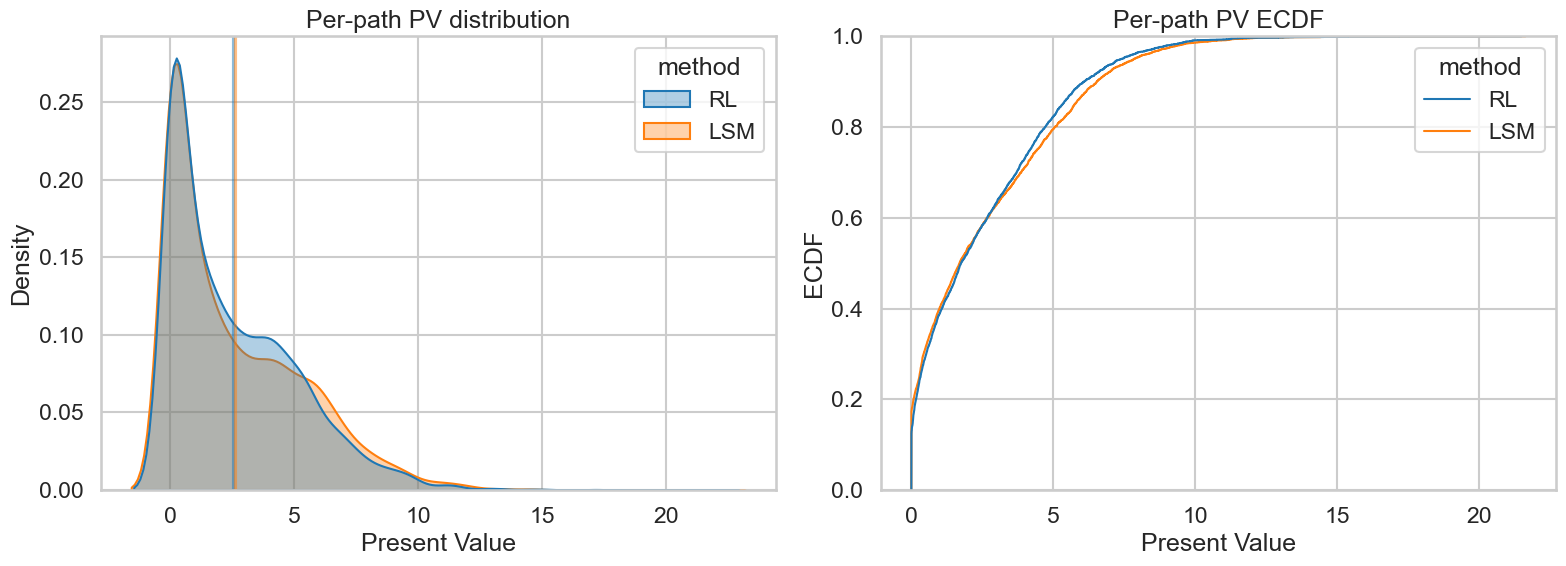

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# KDE plot
sns.kdeplot(data=pp, x='PV', hue='method', fill=True, common_norm=False, alpha=0.35, linewidth=1.5, ax=axes[0])
axes[0].axvline(m_rl, color='tab:blue', ymin=0, ymax=1, alpha=0.5, label=f'RL Mean: {m_rl:.4f}')
axes[0].axvline(m_lsm, color='tab:orange', ymin=0, ymax=1, alpha=0.5, label=f'LSM Mean: {m_lsm:.4f}')
axes[0].set_title('Per-path PV distribution')
axes[0].set_xlabel('Present Value')
axes[0].set_ylabel('Density')

# ECDF plot
sns.ecdfplot(data=pp, x='PV', hue='method', linewidth=1.5, ax=axes[1])
axes[1].set_title('Per-path PV ECDF')
axes[1].set_xlabel('Present Value')
axes[1].set_ylabel('ECDF')

plt.tight_layout()
plt.show()

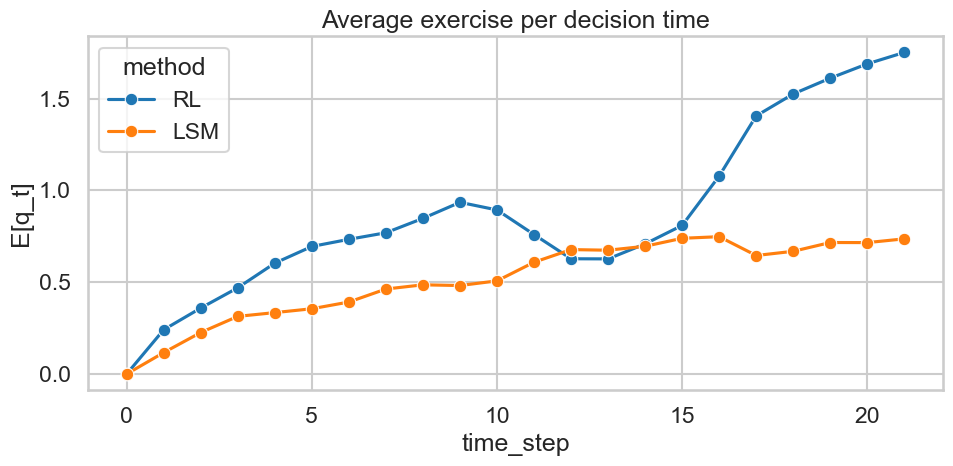

In [25]:
# Average exercise profile over time (mean q_t per time_step)
def avg_profile(df: pd.DataFrame) -> pd.DataFrame:
    return df.groupby('time_step', as_index=False)['q_t'].mean().rename(columns={'q_t':'q_mean'})
prof_rl  = avg_profile(df_rl).assign(method='RL')
prof_lsm = avg_profile(df_lsm).assign(method='LSM')
prof = pd.concat([prof_rl, prof_lsm], ignore_index=True)
plt.figure(figsize=(10,5))
sns.lineplot(data=prof, x='time_step', y='q_mean', hue='method', marker='o')
plt.title('Average exercise per decision time')
plt.xlabel('time_step')
plt.ylabel('E[q_t]')
plt.tight_layout(); plt.show()

### What follows: Average exercise per decision time
Mean q_t at each time step across paths for both methods, revealing differences in temporal allocation policies (front-loading vs back-loading vs uniform).

In [41]:
rl_m

,path,time_step,Payoff,q_exercised_norm,q_remaining_norm,time_to_maturity_norm,normalized_time,spot,X_t,Y_t,days_since_exercise_norm,q_t,reward,moneyness
0,0,0,0.000000,0.000000,1.000000,1.047619,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
1,0,1,0.031942,0.000000,1.000000,1.000000,0.045455,1.031942,0.031442,0.000000,0.045455,0.000000,0.000000,1.031942
2,0,2,0.096026,0.000000,1.000000,0.952381,0.090909,1.096026,0.091691,0.000000,0.090909,1.099322,0.105501,1.096026
3,0,3,0.077425,0.054966,0.945034,0.904762,0.136364,1.077425,0.074574,0.000000,0.045455,1.626424,0.125826,1.077425
4,0,4,0.123920,0.136287,0.863713,0.857143,0.181818,1.123920,0.116822,0.000000,0.045455,1.986800,0.245960,1.123920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87963,4095,17,0.196099,0.513422,0.486578,0.238095,0.772727,1.196099,0.179066,0.000000,0.045455,2.000000,0.390801,1.196099
87964,4095,18,0.101300,0.613422,0.386578,0.190476,0.818182,1.101300,0.096491,0.000000,0.045455,2.000000,0.201838,1.101300
87965,4095,19,0.207498,0.713422,0.286578,0.142857,0.863636,1.207498,0.188550,0.000000,0.045455,2.000000,0.413353,1.207498
87966,4095,20,0.217922,0.813422,0.186578,0.095238,0.909091,1.217922,0.197146,0.000000,0.045455,2.000000,0.434033,1.217922


<Axes: >

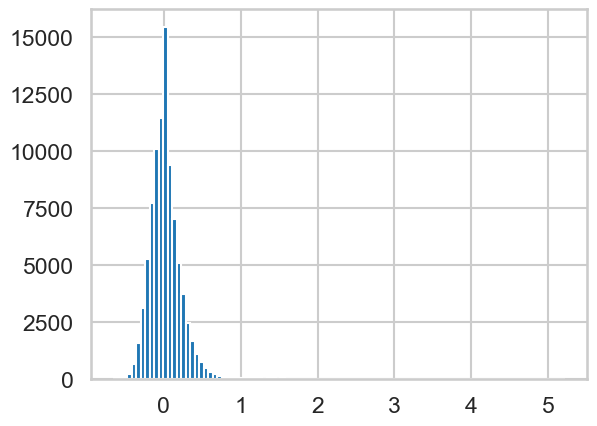

In [64]:
df_rl['Payoff'].hist(bins=100)

/var/folders/57/8q11hb450rz9z_rwvfbzpkmm0000gn/T/ipykernel_11354/2909903259.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_qt_by_quantile = rl_m_quant.groupby(quantile_mid)['q_t'].mean()


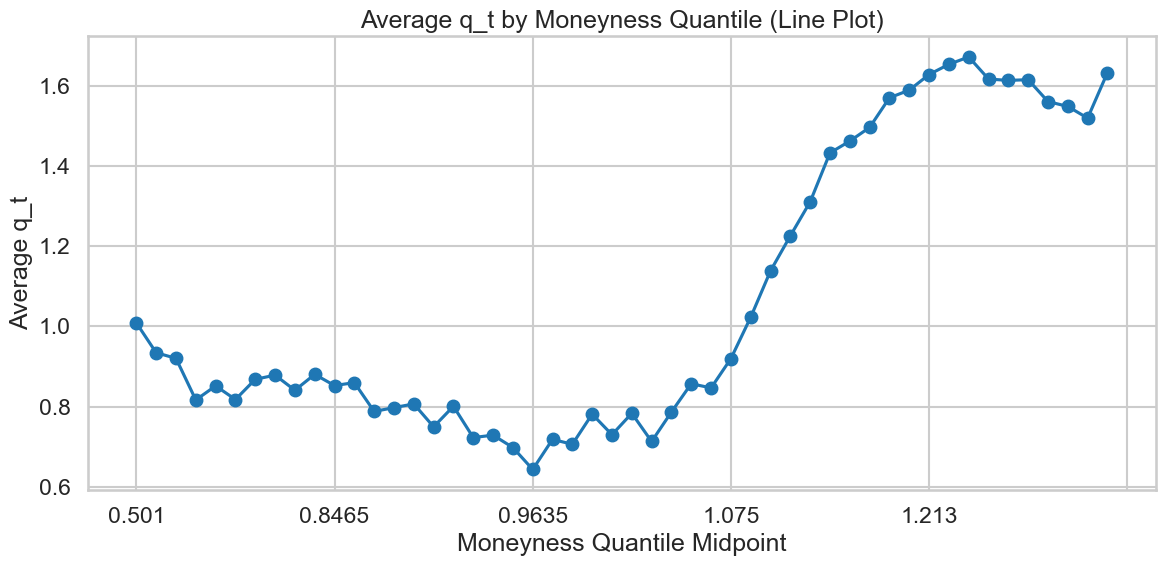

In [ ]:
rl_m = df_rl.copy(deep=True)
rl_m['moneyness'] = rl_m['spot'] / K
rl_m['q_remaining_norm'] = rl_m['q_remaining_norm'] * Q_MAX

lsm_m = df_lsm.copy(deep=True)
lsm_m['moneyness'] = lsm_m['spot'] / K
lsm_m['q_remaining_norm'] = lsm_m['q_exercised_so_far']

n =50  # or any desired number of quantiles
mask = (rl_m['q_remaining_norm'] <= 18)
rl_m_quant = rl_m[mask].copy()
rl_m_quant['moneyness_quantile'] = pd.qcut(rl_m_quant['moneyness'], q=n, duplicates='drop')

quantile_mid = rl_m_quant['moneyness_quantile'].apply(lambda iv: (iv.left + iv.right)/2 if hasattr(iv, 'left') else np.nan)
avg_qt_by_quantile = rl_m_quant.groupby(quantile_mid)['q_t'].mean()
avg_qt_by_quantile.plot(kind='line', marker='o', figsize=(12,6), title='Average q_t by Moneyness Quantile (Line Plot)')
plt.xlabel('Moneyness Quantile Midpoint')
plt.ylabel('Average q_t')
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

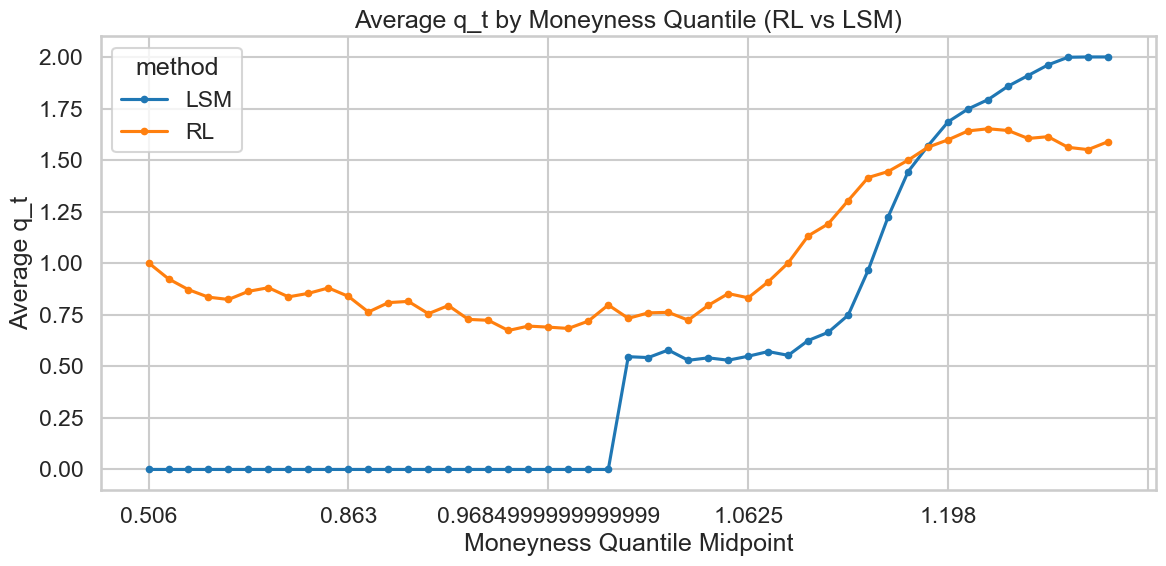

In [72]:
rl_m = df_rl.copy(deep=True)
rl_m['moneyness'] = rl_m['spot'] / K
rl_m['q_remaining_norm'] = rl_m['q_remaining_norm'] * Q_MAX

lsm_m = df_lsm.copy(deep=True)
lsm_m['moneyness'] = lsm_m['spot'] / K
lsm_m['q_remaining_norm'] = lsm_m['q_exercised_so_far']

n = 50  # number of quantiles to use
# combine datasets so quantile bins are shared between methods
combined = pd.concat([rl_m.assign(method='RL'), lsm_m.assign(method='LSM')], ignore_index=True)

# restrict to states with limited remaining quantity (as before)
mask = combined['q_remaining_norm'] <= 18
comb_q = combined[mask].copy()

# create quantile bins on moneyness (shared bins)
comb_q['moneyness_quantile'] = pd.qcut(comb_q['moneyness'], q=n, duplicates='drop')

# map interval -> midpoint for plotting on a continuous x-axis
comb_q['moneyness_mid'] = comb_q['moneyness_quantile'].apply(
    lambda iv: (iv.left + iv.right) / 2 if hasattr(iv, 'left') else np.nan
)

# average q_t per method and quantile-midpoint
avg_by = comb_q.groupby(['method', 'moneyness_mid'], as_index=False, observed=False)['q_t'].mean()

# pivot so we can plot both methods on same axes
pivot = avg_by.pivot(index='moneyness_mid', columns='method', values='q_t').sort_index()

plt.figure(figsize=(12,6))
pivot.plot(kind='line', marker='.', figsize=(12,6))
plt.title('Average q_t by Moneyness Quantile (RL vs LSM)')
plt.xlabel('Moneyness Quantile Midpoint')
plt.ylabel('Average q_t')
plt.legend(title='method')
plt.tight_layout()
plt.show()

/var/folders/57/8q11hb450rz9z_rwvfbzpkmm0000gn/T/ipykernel_11354/471349394.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mn_prof = mn_prof.groupby('method', group_keys=False).apply(lambda df: df.iloc[:-1])


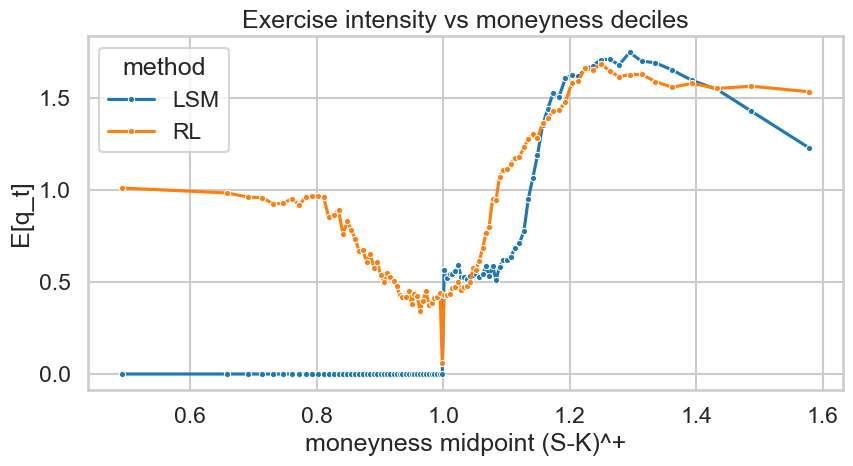

In [ ]:
def add_moneyness(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['moneyness'] = df.get('spot', np.nan) / K
    return df

rl_m = add_moneyness(df_rl)
lsm_m = add_moneyness(df_lsm)

combined = pd.concat([rl_m.assign(method='RL'), lsm_m.assign(method='LSM')], ignore_index=True)
combined = combined[np.isfinite(combined['moneyness'])]
combined['mn_decile'] = pd.qcut(combined['moneyness'], q=100, duplicates='drop')

# Map decile intervals to midpoints for ordered plotting
midpoints = combined['mn_decile'].apply(lambda iv: (iv.left + iv.right)/2 if hasattr(iv, 'left') else np.nan)
combined['mn_mid'] = midpoints
mn_prof = combined.groupby(['method','mn_mid'], as_index=False, observed=True)['q_t'].mean()
mn_prof = mn_prof.groupby('method', group_keys=False).apply(lambda df: df.iloc[:-1])
plt.figure(figsize=(9,5))
sns.lineplot(data=mn_prof, x='mn_mid', y='q_t', hue='method', marker='.', hue_order=['LSM','RL'])
plt.title('Exercise intensity vs moneyness deciles')
plt.xlabel('moneyness midpoint (S-K)^+')
plt.ylabel('E[q_t]')
plt.tight_layout(); plt.show()

### What follows: Exercise intensity vs moneyness
Average q_t within moneyness deciles per method, highlighting responsiveness to in-the-money states and saturation behavior.

## Notes
- PV is computed as the sum over steps of the available discounted payoff signal: `reward` when present (RL includes discounting by design), otherwise `Payoff`.
- LSM serves as the benchmark; inspect delta_mean and relative error to assess bias. For policy diagnostics, compare exercise profiles and moneyness-conditioned intensities.

Brief notes on this section:
- Adds Welch’s two-sample t-tests for per-path PV and first-ex timing to test RL vs LSM differences.
- Computes discrete hazard rates for first exercise h_t = P(T=t | T≥t) and plots them.
- Keeps the final two heatmaps’ values rounded to 4 decimals for presentation parity.
- Cumulative exercise, PV–quantity efficiency, timing distribution, and a bootstrap CI for mean PV delta remain for context.

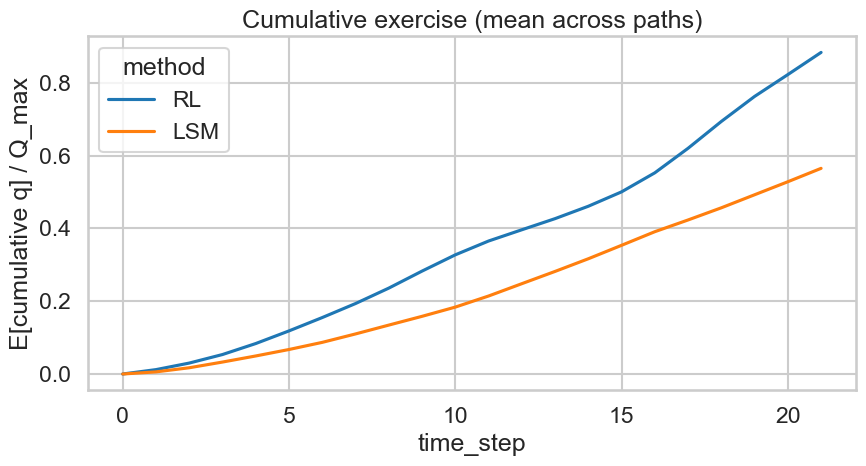

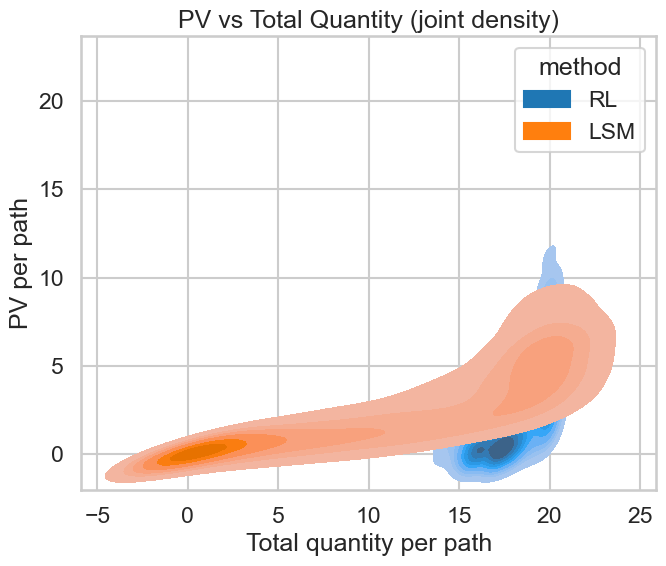

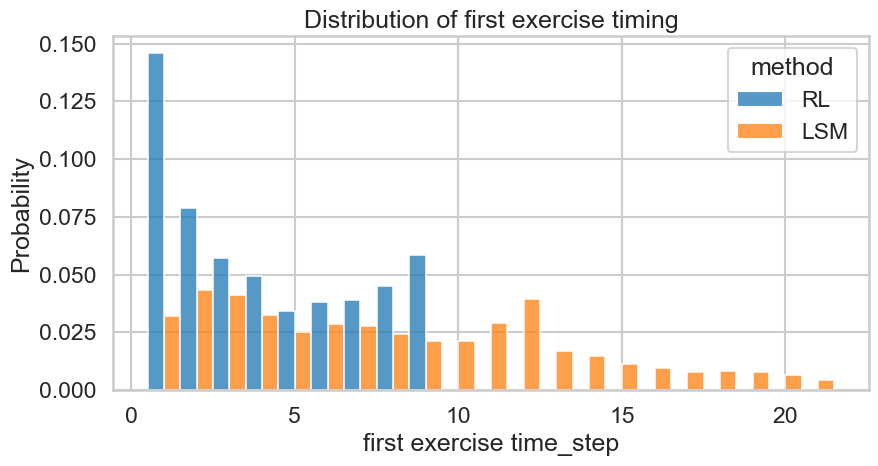

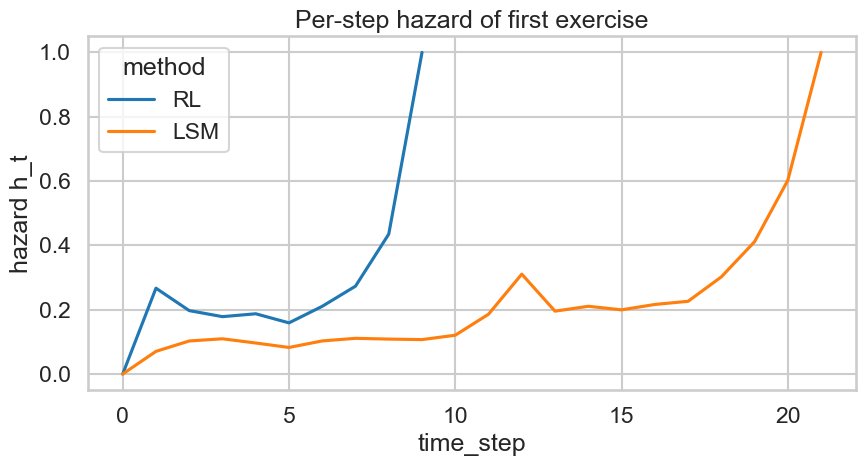

/var/folders/57/8q11hb450rz9z_rwvfbzpkmm0000gn/T/ipykernel_10371/2644982078.py:108: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = d.pivot_table(index='time_step', columns='mny_mid', values='q_t', aggfunc='mean')


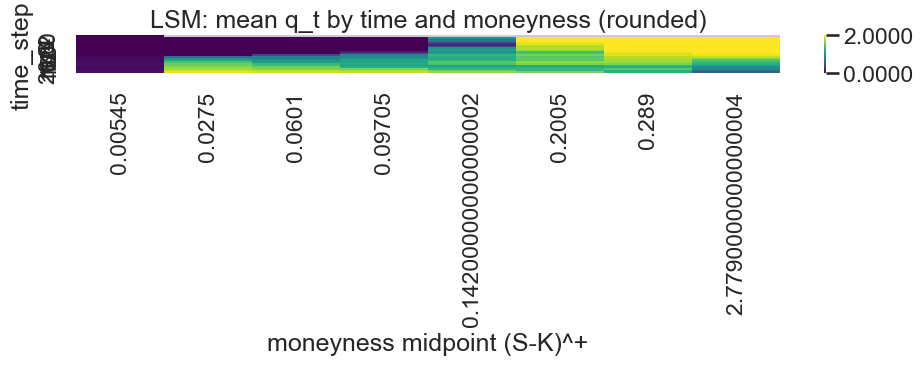

/var/folders/57/8q11hb450rz9z_rwvfbzpkmm0000gn/T/ipykernel_10371/2644982078.py:108: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = d.pivot_table(index='time_step', columns='mny_mid', values='q_t', aggfunc='mean')


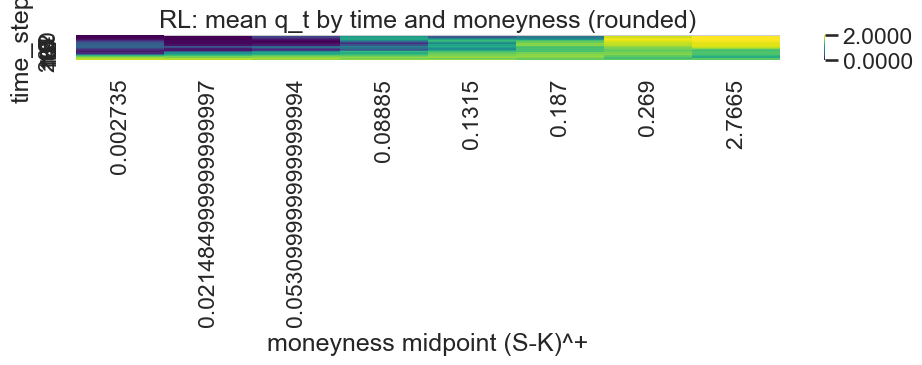

In [32]:
# Additional analyses: quantity allocation, efficiency, timing, significance, state conditioning
from sklearn.utils import resample
from scipy import stats as spstats

# 1) Cumulative exercise curves (mean over paths)
def cumulative_profile(df: pd.DataFrame) -> pd.DataFrame:
    g = df.sort_values(['path','time_step']).copy()
    g['cum_q'] = g.groupby('path')['q_t'].cumsum()
    prof = g.groupby('time_step', as_index=False)['cum_q'].mean()
    prof['cum_q_norm'] = prof['cum_q'] / Q_MAX
    return prof

cum_rl  = cumulative_profile(df_rl).assign(method='RL')
cum_lsm = cumulative_profile(df_lsm).assign(method='LSM')
cum_all = pd.concat([cum_rl, cum_lsm], ignore_index=True)
plt.figure(figsize=(9,5))
sns.lineplot(data=cum_all, x='time_step', y='cum_q_norm', hue='method')
plt.title('Cumulative exercise (mean across paths)')
plt.xlabel('time_step')
plt.ylabel('E[cumulative q] / Q_max')
plt.tight_layout(); plt.show()

# 2) PV vs total quantity: efficiency slope and joint density
plt.figure(figsize=(7,6))
sns.kdeplot(data=pp, x='Q_total', y='PV', hue='method', fill=True, thresh=0.05)
plt.title('PV vs Total Quantity (joint density)')
plt.xlabel('Total quantity per path')
plt.ylabel('PV per path')
plt.tight_layout(); plt.show()

eff_rows = []
for name, grp in pp.groupby('method'):
    x = grp['Q_total'].values; y = grp['PV'].values
    slope = np.cov(x,y, ddof=1)[0,1] / np.var(x, ddof=1) if np.var(x, ddof=1) > 0 else np.nan
    eff_rows.append({'method': name, 'efficiency_slope': slope})
pd.DataFrame(eff_rows).set_index('method')

# 3) First-exercise timing distribution and hazard rates
def first_exercise_step(df: pd.DataFrame) -> pd.DataFrame:
    tmp = df.copy()
    tmp['is_ex'] = tmp['q_t'] > 1e-8
    first = tmp[tmp['is_ex']].groupby('path', as_index=False)['time_step'].min()
    first = first.rename(columns={'time_step':'first_ex'})
    first['first_ex'] = first['first_ex'].astype(int)
    return first

f_rl = first_exercise_step(df_rl).assign(method='RL')
f_lsm = first_exercise_step(df_lsm).assign(method='LSM')
f_all = pd.concat([f_rl, f_lsm], ignore_index=True)
plt.figure(figsize=(9,5))
sns.histplot(data=f_all, x='first_ex', hue='method', kde=False, stat='probability', discrete=True, multiple='dodge')
plt.title('Distribution of first exercise timing')
plt.xlabel('first exercise time_step')
plt.ylabel('Probability')
plt.tight_layout(); plt.show()

# Hazard rate h_t = P(first_ex = t | first_ex >= t)
def hazard_from_first_ex(first_df: pd.DataFrame, nT: int) -> pd.DataFrame:
    counts = first_df['first_ex'].value_counts().reindex(range(nT), fill_value=0).astype(float)
    survivors = counts[::-1].cumsum()[::-1]
    denom = survivors.copy()
    denom[denom==0] = np.nan
    hazard = counts / denom
    return pd.DataFrame({'time_step': range(nT), 'hazard': hazard.values})

nT = int(df_rl['time_step'].max()) + 1
hz_rl  = hazard_from_first_ex(f_rl, nT).assign(method='RL')
hz_lsm = hazard_from_first_ex(f_lsm, nT).assign(method='LSM')
hz_all = pd.concat([hz_rl, hz_lsm], ignore_index=True)
plt.figure(figsize=(9,5))
sns.lineplot(data=hz_all, x='time_step', y='hazard', hue='method')
plt.title('Per-step hazard of first exercise')
plt.xlabel('time_step')
plt.ylabel('hazard h_t')
plt.tight_layout(); plt.show()

# 4) Bootstrap CI for mean delta (RL−LSM)
def bootstrap_delta(pp_rl: pd.DataFrame, pp_lsm: pd.DataFrame, B=2000, seed=42):
    rng = np.random.default_rng(seed)
    rl_vals = pp_rl['PV'].values
    lsm_vals = pp_lsm['PV'].values
    deltas = []
    n = min(len(rl_vals), len(lsm_vals))
    for _ in range(B):
        idx_r = rng.integers(0, len(rl_vals), size=n)
        idx_l = rng.integers(0, len(lsm_vals), size=n)
        deltas.append(rl_vals[idx_r].mean() - lsm_vals[idx_l].mean())
    return np.mean(deltas), np.percentile(deltas, [2.5, 97.5])

b_mean, (b_lo, b_hi) = bootstrap_delta(pp_rl, pp_lsm)
{'bootstrap_delta_mean': b_mean, 'CI95': (b_lo, b_hi)}

# 5) Welch's t-tests: PV and first-ex timing
pv_t = spstats.ttest_ind(pp_rl['PV'].values, pp_lsm['PV'].values, equal_var=False)
# Align first-ex arrays by inner join on paths (or compare samples as-is)
t_rl = f_rl['first_ex'].values
t_lsm = f_lsm['first_ex'].values
first_ex_t = spstats.ttest_ind(t_rl, t_lsm, equal_var=False)
{'pv_t_stat': pv_t.statistic, 'pv_pvalue': pv_t.pvalue, 'first_ex_t_stat': first_ex_t.statistic, 'first_ex_pvalue': first_ex_t.pvalue}

# 6) State-conditioned heatmaps (time vs moneyness) of mean q_t (rounded to 4 decimals)
def state_heat(df: pd.DataFrame, title: str):
    d = df.copy()
    d['mny'] = np.maximum(d.get('spot', np.nan) - K, 0.0)
    d = d[np.isfinite(d['mny'])]
    d['mny_bin'] = pd.qcut(d['mny'], q=15, duplicates='drop')
    d['mny_mid'] = d['mny_bin'].apply(lambda iv: (iv.left + iv.right)/2 if hasattr(iv,'left') else np.nan)
    pivot = d.pivot_table(index='time_step', columns='mny_mid', values='q_t', aggfunc='mean')
    pivot = pivot.round(4)
    plt.figure(figsize=(10,4))
    sns.heatmap(pivot, cmap='viridis', cbar_kws={'format': '%.4f'})
    plt.title(title)
    plt.xlabel('moneyness midpoint (S-K)^+')
    plt.ylabel('time_step')
    plt.tight_layout(); plt.show()

state_heat(df_lsm, 'LSM: mean q_t by time and moneyness (rounded)')
state_heat(df_rl,  'RL: mean q_t by time and moneyness (rounded)')